In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv("Data/data.csv",
                 usecols=['Date', 'open', 'high', 'low', 'close', 'vol'],
                 parse_dates=['Date'],
                 index_col=['Date'],)
data.head(10)

,open,high,low,close,vol
Date,,,,,
2012-01-01,873.0,879.0,851.0,879.0,799
2012-01-02,879.0,913.0,882.0,900.0,1002
2012-01-03,900.0,916.0,892.0,892.0,2653
2012-01-04,892.0,875.0,842.0,865.0,490
2012-01-05,865.0,875.0,858.0,858.0,121
2012-01-08,858.0,845.0,814.0,830.0,4835
2012-01-09,830.0,846.0,830.0,846.0,195
2012-01-10,858.0,862.0,845.0,845.0,658
2012-01-11,845.0,874.0,845.0,874.0,969


In [3]:
data.isnull().sum() #checking for nullity

open     0
high     0
low      0
close    0
vol      0
dtype: int64

In [4]:
def plot_graph(record):      # reusale function for plotting purposes
    plt.figure(figsize=(20,12))
    plt.plot(record)

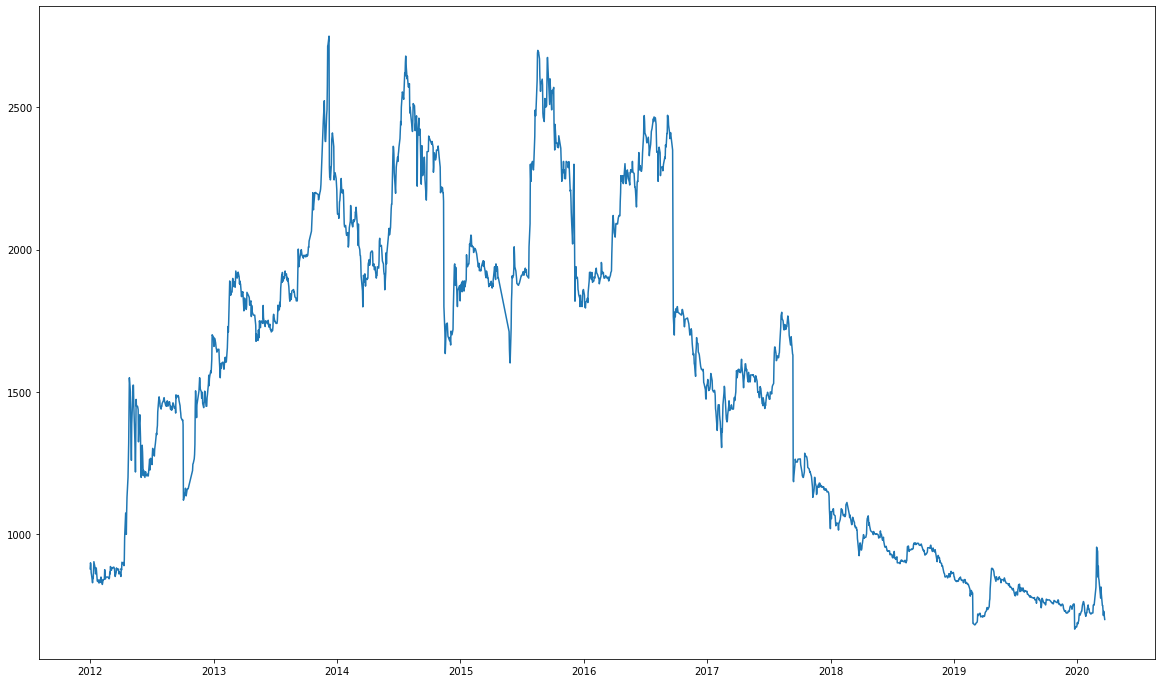

In [5]:
plot_graph(data.close)

In [6]:
data=data[['close']]
data.tail()

,close
Date,
2020-03-16,750.0
2020-03-17,731.0
2020-03-18,715.0
2020-03-19,730.0
2020-03-22,701.0


In [7]:
data.close=data.close.resample("W").mean()  #smoothing the data by resampling it in week period
data.dropna(inplace=True)
data.head(10)

,close
Date,
2012-01-01,879.000000
2012-01-08,869.000000
2012-01-22,864.500000
2012-01-29,833.750000
2012-02-05,838.250000
2012-02-12,835.600000
2012-02-26,848.000000
2012-03-04,867.200000
2012-03-11,883.333333


### The curve is smoother than the previous one

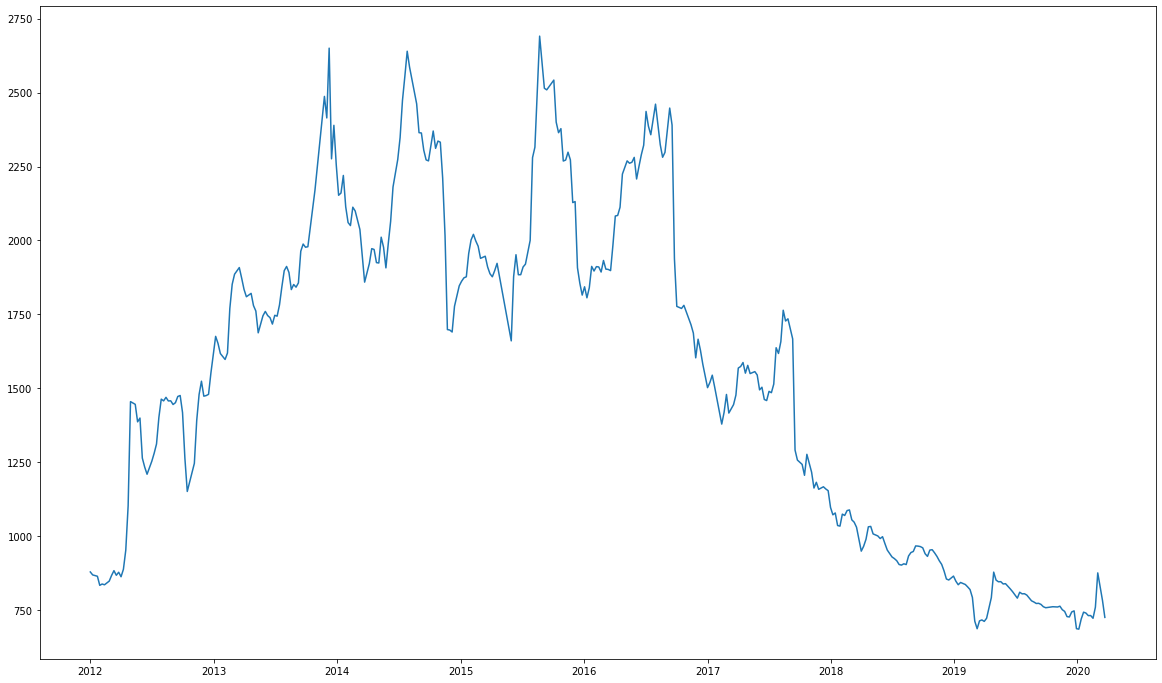

In [8]:
plot_graph(data.close) 

## Cheking for stationarity of time series

In [9]:
from statsmodels.tsa.stattools import adfuller

#Ho: It is not stationary
#H1: It is stationary

def adfuller_test(records):
    result=adfuller(records)
    labels=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for label,value in zip(labels,result):
        print(label+" : "+str(value))
    if result[1]<=0.05:
        print("Null hypothesis is rejected. Series is stationary.")
    else:
        print("Null hypothesis is accepted. Series in not stationary.")

In [10]:
adfuller_test(data.close)

ADF Test Statistic : -1.5935367271274512
p-value : 0.48683941293703936
#Lags Used : 2
Number of Observations Used : 376
Null hypothesis is accepted. Series in not stationary.


In [11]:
first_difference=data['close']-data['close'].shift(1)

In [12]:
adfuller_test(first_difference.dropna())

ADF Test Statistic : -11.510902375472913
p-value : 4.2623680183828935e-21
#Lags Used : 1
Number of Observations Used : 376
Null hypothesis is rejected. Series is stationary.


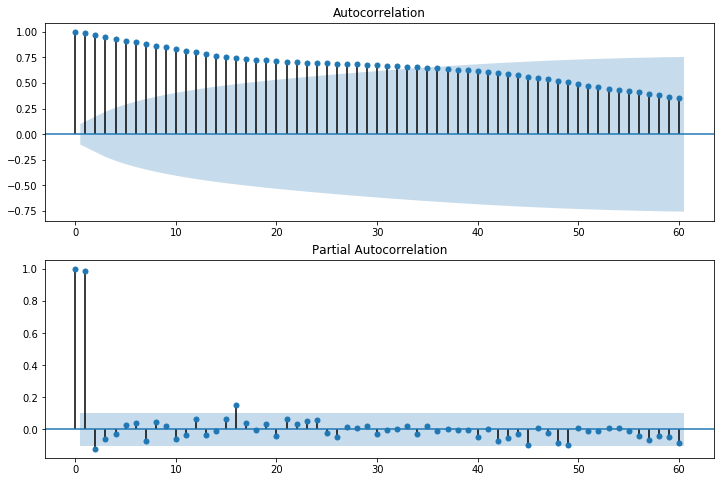

In [13]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data['close'].dropna(),lags=60,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data['close'].dropna(),lags=60,ax=ax2)

In [14]:
from statsmodels.tsa.arima_model import ARIMA

model=ARIMA(data['close'],order=(1,1,0))
model_fit=model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  378
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2171.118
Method:                       css-mle   S.D. of innovations             75.545
Date:                Sat, 29 Aug 2020   AIC                           4348.236
Time:                        11:33:48   BIC                           4360.041
Sample:                             1   HQIC                          4352.921
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4377      4.583     -0.095      0.924      -9.421       8.545
ar.L1.D.close     0.1526      0.051      3.004      0.003       0.053       0.252
                                    Root

/home/bishesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/bishesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


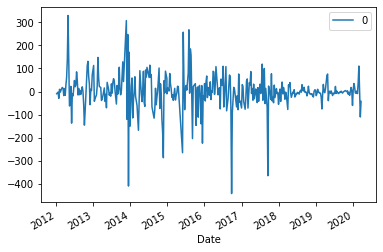

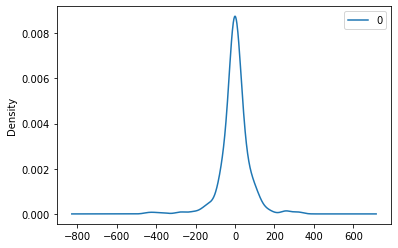

In [15]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')

In [16]:
residuals.describe()

,0
count,378.000000
mean,0.003586
std,75.645216
min,-442.505759
25%,-21.536720
50%,-1.720060
75%,26.495989
max,329.737888


In [17]:
X=data.close.values
len(X)

379

In [18]:
size = int(len(X) * 0.66)  #splitting of data into train and test set
train, test = X[0:size], X[size:len(X)]
actual_train = [x for x in train]
predictions=list()

In [19]:
for t in range(len(test)):
    model = ARIMA(actual_train, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    prediction = output[0]
    predictions.append(prediction)
    test_value = test[t]
    actual_train.append(test_value)
    print('%d. predicted=%f, expected=%f'%(t+1,prediction,test_value))

1. predicted=1520.659174, expected=1637.200000
2. predicted=1658.175210, expected=1617.800000
3. predicted=1617.448136, expected=1658.000000
4. predicted=1666.527225, expected=1764.000000
5. predicted=1782.715267, expected=1727.500000
6. predicted=1725.030136, expected=1735.000000
7. predicted=1738.951858, expected=1667.000000
8. predicted=1659.743080, expected=1291.200000
9. predicted=1232.955320, expected=1257.333333
10. predicted=1253.344184, expected=1242.666667
11. predicted=1241.582938, expected=1205.800000
12. predicted=1201.154256, expected=1276.750000
13. predicted=1288.909264, expected=1246.750000
14. predicted=1243.375457, expected=1216.400000
15. predicted=1212.858428, expected=1162.800000
16. predicted=1155.500063, expected=1182.200000
17. predicted=1186.118751, expected=1158.400000
18. predicted=1155.663641, expected=1167.000000
19. predicted=1169.215628, expected=1159.600000
20. predicted=1159.357132, expected=1153.800000
21. predicted=1153.778655, expected=1097.250000
2

In [20]:
from sklearn.metrics import mean_squared_error
import math

error=mean_squared_error(test,predictions)
rmse=math.sqrt(error)
print(f'The mean squared error is {error}')
print(f'The rmse is {rmse}')

The mean squared error is 2052.8951174897306
The rmse is 45.308885635046586


In [21]:
rng=data.iloc[250:,:].index
pred=pd.DataFrame(data=predictions,index=rng,columns=['prediction'])
print(data.shape)
print(len(test))

(379, 1)
129


In [22]:
data.iloc[250:,:].index

DatetimeIndex(['2017-07-23', '2017-07-30', '2017-08-06', '2017-08-13',
               '2017-08-20', '2017-08-27', '2017-09-10', '2017-09-17',
               '2017-09-24', '2017-10-08',
               ...
               '2020-01-12', '2020-01-19', '2020-01-26', '2020-02-02',
               '2020-02-09', '2020-02-16', '2020-02-23', '2020-03-01',
               '2020-03-15', '2020-03-22'],
              dtype='datetime64[ns]', name='Date', length=129, freq=None)

## The model worked well in test data

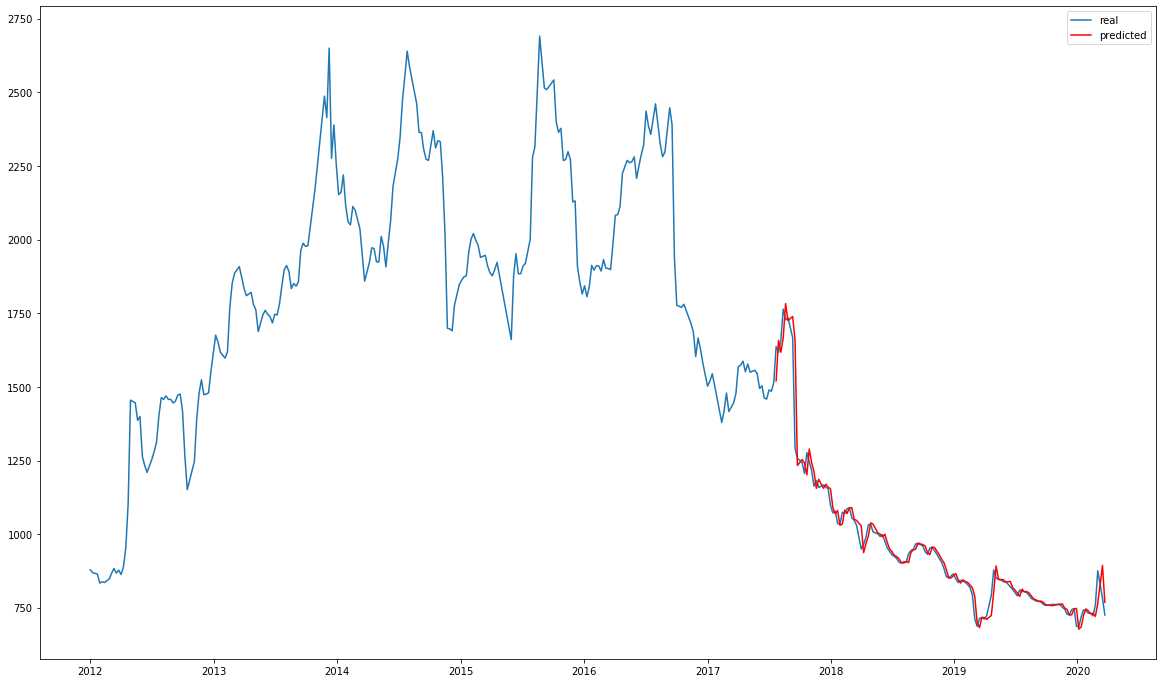

In [23]:
plt.figure(figsize=(20,12))
plt.plot(data,label="real")
plt.plot(pred,color='red',label='predicted')
plt.legend()

## Forecasting closing price for next 20 weeks.
It is to be kept in mind that as we keep moving in forecasting period(towards the end of 20 weeks period), the       uncertainity in the prediction increases.

I have implemented 2 methods of forecasting:<br/>
* using forecast() function of ARIMA. <br/>
* training ARIMA again for next 20 weeks, appending the predicted value in training list.

In [24]:
forecast_20=model_fit.forecast(steps=20)

In [25]:
rng_20=pd.date_range(start="2020-03-23",end="2020-08-12",freq='W')
len(rng_20)

20

In [26]:
rng_20

DatetimeIndex(['2020-03-29', '2020-04-05', '2020-04-12', '2020-04-19',
               '2020-04-26', '2020-05-03', '2020-05-10', '2020-05-17',
               '2020-05-24', '2020-05-31', '2020-06-07', '2020-06-14',
               '2020-06-21', '2020-06-28', '2020-07-05', '2020-07-12',
               '2020-07-19', '2020-07-26', '2020-08-02', '2020-08-09'],
              dtype='datetime64[ns]', freq='W-SUN')

In [33]:
forecast=pd.DataFrame(data=forecast_20[0],index=rng_20,columns=['forecast'])
forecast.head(10)

,forecast
2020-03-29,768.460105
2020-04-05,766.046954
2020-04-12,765.424774
2020-04-19,765.072666
2020-04-26,764.761284
2020-05-03,764.456043
2020-05-10,764.151729
2020-05-17,763.847554
2020-05-24,763.543400
2020-05-31,763.239249


In [28]:
from tqdm import tqdm

## Method 2

In [29]:
forecasts=list()
forecast_train=actual_train.copy()
for t in tqdm(range(20)):
    model2 = ARIMA(forecast_train, order=(1,1,0))
    model_fit2 = model2.fit(disp=0)
    output = model_fit2.forecast()
    forecast = output[0]
    forecasts.append(forecast)
    forecast_train.append(forecast)

100%|██████████| 20/20 [00:00<00:00, 31.31it/s]


In [30]:
sample_forecasted=pd.DataFrame(data=forecasts,index=rng_20,columns=['forecast'])

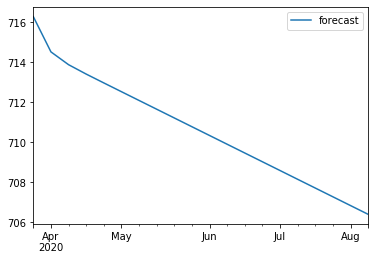

In [31]:
sample_forecasted.plot()

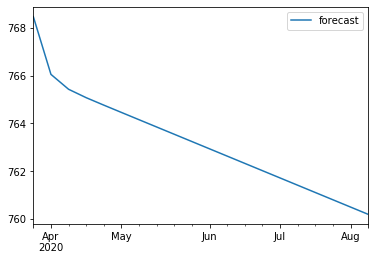

In [34]:
forecast.plot()

### The 2nd method seems to be working well. So code in kernels below uses the prediction from this method.
I have spliced the dataframe to get recent data(>=2019) and concatenated it with predicted value. If concatenation is not to done, there occurs discontinuity in the graph. This is because two different dataframes are plotted, terminating value of 1st and initiating value of 2nd dataframe doesn't coincide at a point resulting in discontinuity.

In [35]:
recent_data=data["2019":].copy()
recent_data.columns=['forecast']
recent_data.head()

,forecast
Date,
2019-01-06,847.8
2019-01-13,835.8
2019-01-20,843.4
2019-01-27,840.2
2019-02-03,836.6


## Discontinuous Graph

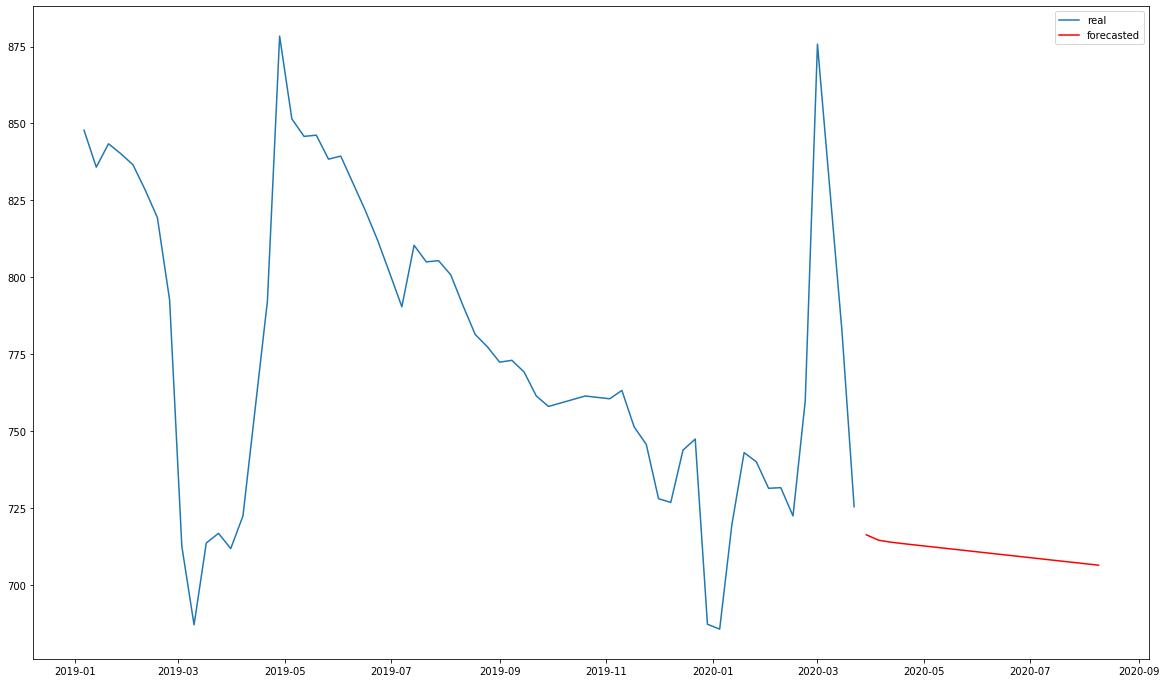

In [36]:
plt.figure(figsize=(20,12))
plt.plot(recent_data,label="real")
plt.plot(sample_forecasted,color='red',label='forecasted')
plt.legend()

In [37]:
collective_data=pd.concat([recent_data,sample_forecasted])
collective_data.head()

,forecast
2019-01-06,847.8
2019-01-13,835.8
2019-01-20,843.4
2019-01-27,840.2
2019-02-03,836.6


Text(2020-03-29 00:00:00, 720, 'Forecast begins here')

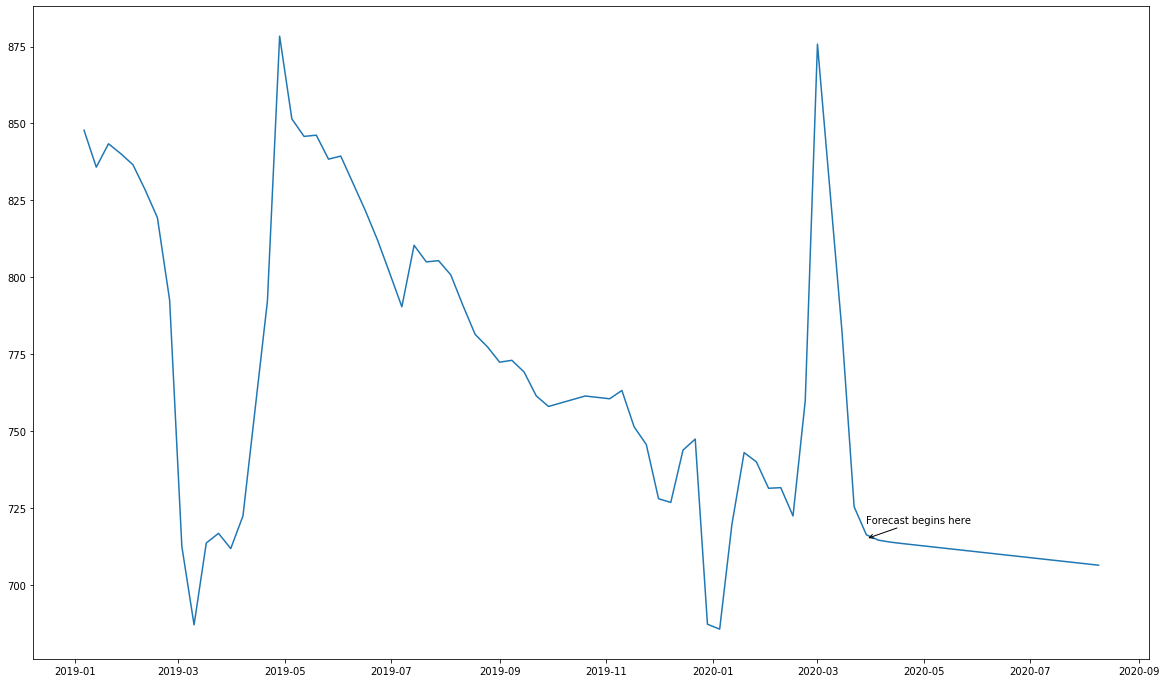

In [38]:
from datetime import datetime
plt.figure(figsize=(20,12))
plt.plot(collective_data)
plt.annotate("Forecast begins here",
             xy= (datetime(2020,3,29), 715),
             arrowprops=dict(arrowstyle="->"),
             xytext=(datetime(2020,3,29), 720))

In [44]:
#forecast = forecast.rename(columns= {"forecast":"close"})
#forecast = forecast.reset_index(drop = False)
forecast = forecast.rename(columns = {"index":"Date"})
#forecast = forecast.drop(['level_0'], axis = 1)
forecast

,Date,close
0,2020-03-29,768.460105
1,2020-04-05,766.046954
2,2020-04-12,765.424774
3,2020-04-19,765.072666
4,2020-04-26,764.761284
5,2020-05-03,764.456043
6,2020-05-10,764.151729
7,2020-05-17,763.847554
8,2020-05-24,763.543400
9,2020-05-31,763.239249


In [45]:
prev_data = data.close
prev_data = pd.DataFrame(prev_data)

In [46]:
prev_data = prev_data.reset_index()

In [47]:
prev_data

,Date,close
0,2012-01-01,879.00
1,2012-01-08,869.00
2,2012-01-22,864.50
3,2012-01-29,833.75
4,2012-02-05,838.25
...,...,...
374,2020-02-16,722.40
375,2020-02-23,759.80
376,2020-03-01,875.80
377,2020-03-15,782.75


In [48]:
new_data = prev_data.append(forecast)


In [49]:
new_data

,Date,close
0,2012-01-01,879.000000
1,2012-01-08,869.000000
2,2012-01-22,864.500000
3,2012-01-29,833.750000
4,2012-02-05,838.250000
...,...,...
15,2020-07-12,761.414349
16,2020-07-19,761.110198
17,2020-07-26,760.806048
18,2020-08-02,760.501898


In [50]:
new_data = new_data.reset_index(drop = True)
new_data

,Date,close
0,2012-01-01,879.000000
1,2012-01-08,869.000000
2,2012-01-22,864.500000
3,2012-01-29,833.750000
4,2012-02-05,838.250000
...,...,...
394,2020-07-12,761.414349
395,2020-07-19,761.110198
396,2020-07-26,760.806048
397,2020-08-02,760.501898


In [51]:
new_data.to_csv('Data/forecast.csv')